# Importing Required Librarires

In [1]:
%matplotlib inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading Data

The data files were preprocessed on PySpark (10 nodes) cluster. The code for the same can be found [here](.emr_processing/DataProcessing.ipynb). The preprocessed is a numpy array with `4144531` rows with following columns (zero-indexed):
* Col 0-9: projections on first 10 eigen vectors
* Col 10: rmse
* Col 11: peak2peak
* Col 12: label (`0 if row.species==u'Gervais' else 1`)

In [2]:
data  = np.load("data/data.np")
X = data[:, :-1]
y = np.array(data[:, -1], dtype=int)

# Train - Test - Validation

The data is shuffled and divided as follow:
* Training: 70%
* Validation: 15%
* Testing: 15%

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model Training

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3
* Step size shrinkage used in update to prevents overfitting = 0.3
* Evaluation Criterion: `Maximize Loglikelihood`
* Maximum Number of Iterations = 100
* Early Stop if score on Validation does not improve for 5 iterations

In [4]:
param = {'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic'}
param['nthread'] = 7
param['eval_metric'] = 'logloss'
plst = param.items()
num_round = 100
evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(plst, dtrain, num_round, evallist, early_stopping_rounds=5, verbose_eval=False)

## Visualize the Feature Importance

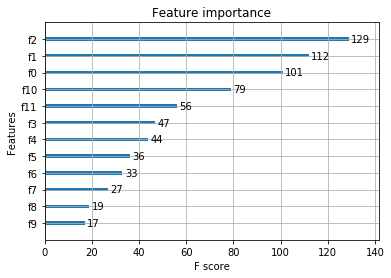

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [5]:
xgb.plot_importance(bst)
plt.show()
features_map = {'f0' : 'Eigen Projection 1', 'f1' : 'Eigen Projection 2',
                'f2' : 'Eigen Projection 3', 'f3' : 'Eigen Projection 4',
                'f4' : 'Eigen Projection 5', 'f5' : 'Eigen Projection 6',
                'f6' : 'Eigen Projection 7', 'f7' : 'Eigen Projection 8',
                'f8' : 'Eigen Projection 9', 'f9' : 'Eigen Projection 10',
                'f10' : 'RMSE', 'f11' : 'Peak2Peak'}

print("Feature Mapping:")
for x in features_map:
    print(x, "\t: ", features_map[x])

Clearly, Eigen Projection 2, Eigen Projection 3, Eigen Projection 1, RMSE and Peak2Peak are the most important features.

# Margin Plots on Test Data

In [6]:
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [7]:
thresholds = sorted(np.unique(np.round(ypred, 2)))
accuracy_cuviers = []
accuracy_gervais = []
for thresh in thresholds:
    y_test_i = y_test[y_test == 1]
    y_pred = ypred[y_test == 1]
    correct = np.sum(y_pred > thresh)
    accuracy_cuviers.append(1.0 * correct / len(y_test_i))
    
    y_test_i = y_test[y_test == 0]
    y_pred = ypred[y_test == 0]
    correct = np.sum(y_pred <= thresh)
    accuracy_gervais.append(1.0 * correct / len(y_test_i))

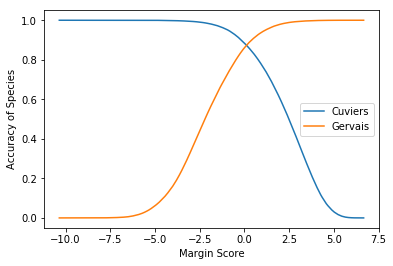

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(thresholds, accuracy_cuviers)
plt.plot(thresholds, accuracy_gervais)
plt.legend(['Cuviers', 'Gervais'])
plt.xlabel('Margin Score')
plt.ylabel('Accuracy of Species')
plt.show()

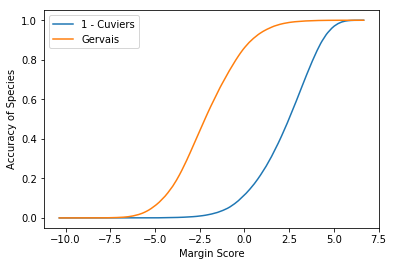

In [9]:
plt.plot(thresholds, 1- np.array(accuracy_cuviers))
plt.plot(thresholds, accuracy_gervais)
plt.legend(['1 - Cuviers', 'Gervais'])
plt.xlabel('Margin Score')
plt.ylabel('Accuracy of Species')
plt.show()